In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist
from stackocat import QSOcat
from read_cats import GetSDSSCat

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5), 90:(20,20)}
boxsize = {250:51, 350:39, 500:27, 90:40}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results_filt_H-ATLAS_W4'

zbins = [(1.,5.)]#[(1.,2.15), (2.15,2.50),(2.50,5.0)]

rmax = 9

extras_names = [
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w1 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w1 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w1 magnitude WISE
    'CC_FLAGS',     # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


## Few functions

In [157]:
def GetS2N(cuts, lam):
    cut = cuts.copy()
    cut += 1e1
#     cut = cut - cut.mean()
    X, Y = np.meshgrid(np.arange(-cut.shape[1]/2, cut.shape[1]/2), np.arange(-cut.shape[0]/2, cut.shape[0]/2))
    R = np.sqrt(X**2+Y**2)
   
    circle = cut[R <= 1.*psf[lam]/reso[lam]]
    rest   = cut[R > 2.*psf[lam]/reso[lam]]
            
    return circle.mean()/rest.mean()

def GetMeIndex(cuts, lam, snr=5.):
    ind = []
    for i, cut in enumerate(cuts):
        if GetS2N(cut, lam) > snr:
            ind.append(i)
        else:
            pass
    return np.asarray(ind)

def ComputeS2N(cuts, lam):
    s2n = []
    for i, cut in enumerate(cuts):
        s2n.append(GetS2N(cut, lam))
    return s2n

def AmIResolved(cuts, lam, sigma=3.):
    s2n = ComputeS2N(cuts, lam)
    stamps = np.where(s2n > sigma*np.std(s2n) + np.mean(s2n))[0]
    return stamps

def AmIReallyResolved(cuts, lam, patch, zbin=0):
    idx = []
    for i in xrange(len(cuts.cuts[lam][patch][zbin])):
        pars, errs = cuts.GaussFit(250, 'G15', zbin, full=i, plot=0, return_errs=True)
        if (pars.amplitude > 0.) and (pars.amplitude/errs>2.):
            idx.append(i)
    return np.asarray(idx)

## Reading cutouts

In [158]:
anal = CutoutAnalysis(results_folder, zbins=zbins, extras_names=extras_names, lambdas=lambdas)

250 1.0 5.0 19.223059551
350 1.0 5.0 13.5803510601
500 1.0 5.0 7.22013929004


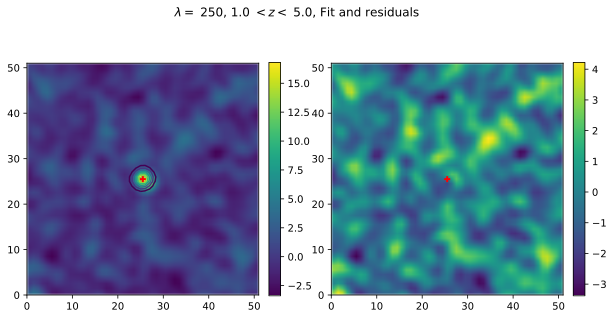

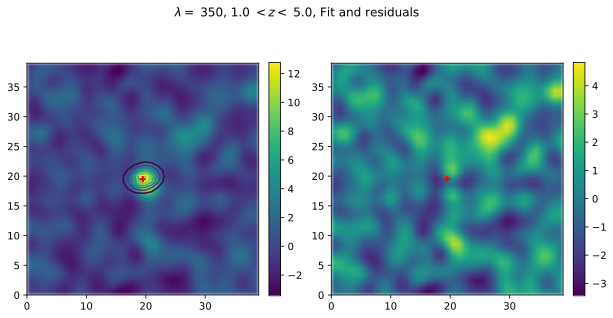

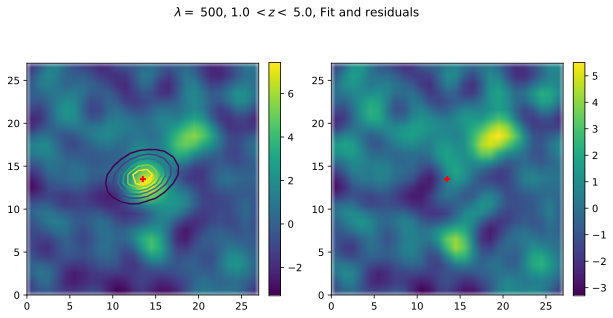

In [161]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=0, remove_mean=False, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value
#             plt.savefig('H-ATLAS_filtered_'+str(lambda_)+'_'+str(zbin[0])+'_'+str(zbin[1])+'.pdf')

In [33]:
for idz, zbin in enumerate(zbins):
    print len(anal.cuts[250]['G9'][idz]) + len(anal.cuts[250]['G12'][idz]) + len(anal.cuts[250]['G15'][idz])

54


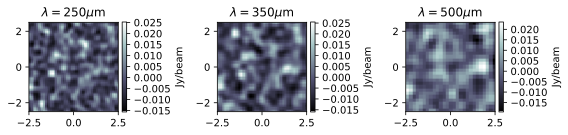

In [101]:
i = 10
patch = 'G15'
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.title(r'$\lambda=250\mu$m')
plt.imshow(anal.cuts[250][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.subplot(132)
plt.title(r'$\lambda=350\mu$m')
plt.imshow(anal.cuts[350][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.subplot(133)
plt.title(r'$\lambda=500\mu$m')
plt.imshow(anal.cuts[500][patch][0][i],extent=[-2.5,2.5,-2.5,2.5],cmap='bone');plt.colorbar(label='Jy/beam',fraction=0.046, pad=0.04);
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/StacktSZ/W4_selected_HotDOG_notsonice.pdf')

In [38]:
anal.extras[250]['G12'][0]['Z']

array([ 2.75214529,  1.26586676,  2.71226907,  2.70440578,  3.03428936,
        1.55327868,  2.08099723,  3.63370228,  1.69880879,  1.33139873,
        1.7177819 ,  1.39525437,  2.60009265,  1.07991934])

In [39]:
from astropy.io import fits

In [49]:
a, h = fits.getdata('/Volumes/LACIE_SHARE/Data/H-ATLAS/G9/HATLAS_GAMA9_DR1_FILT_BACKSUB250.FITS', header=1)

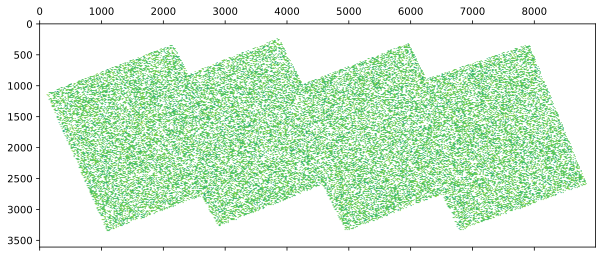

In [82]:
plt.matshow( np.log10(a))

In [105]:
for lam in lambdas:
    print lam, anal.GaussFitTotZ(lam, remove_mean=False).amplitude, anal.GetTotZBootstrapErrsFit2D(lam, remove_mean=False, nsim=300)

250 Parameter('amplitude', value=19.2230602236) 3.99006008225
350 Parameter('amplitude', value=13.580351814) 3.39958827235
500 Parameter('amplitude', value=7.22013963201) 2.03901468276


In [14]:
GetMeIndex(anal.cuts[250]['G9'][0], 250)

array([], dtype=float64)

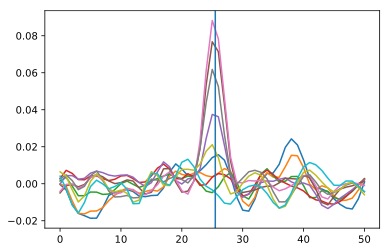

In [205]:
for i in xrange(20,30):
    plt.plot(anal.cuts[250]['G15'][0][2][i,:])
plt.axvline(25.5)

In [57]:
len(AmIReallyResolved(anal, 250, 'G15')) + len(AmIReallyResolved(anal, 250, 'G12')) + len(AmIReallyResolved(anal, 250, 'G9'))

10

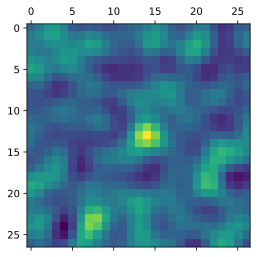

In [56]:
plt.matshow(anal.cuts[500]['G15'][0][2])
# plt.plot(25.5,25.5,'w+',)

In [162]:
HotDOGs_250 = []
HotDOGs_350 = []
HotDOGs_500 = []

for patch in patches:
    HotDOGs_250.append(anal.cuts[250][patch][0][AmIReallyResolved(anal, 250, patch)])
    HotDOGs_350.append(anal.cuts[350][patch][0][AmIReallyResolved(anal, 350, patch)])
    HotDOGs_500.append(anal.cuts[500][patch][0][AmIReallyResolved(anal, 500, patch)])

In [163]:
HotDOGs_250 = np.concatenate(np.asarray(HotDOGs_250), axis=0)
HotDOGs_350 = np.concatenate(np.asarray(HotDOGs_350), axis=0)
HotDOGs_500 = np.concatenate(np.asarray(HotDOGs_500), axis=0)

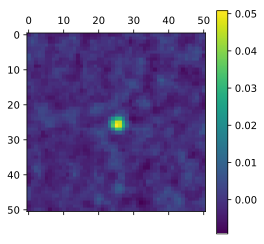

In [164]:

plt.matshow(np.median(HotDOGs, axis=0));plt.colorbar()
# plt.plot(25.5,25.5,'w+',)

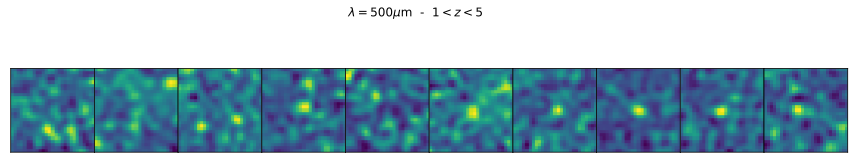

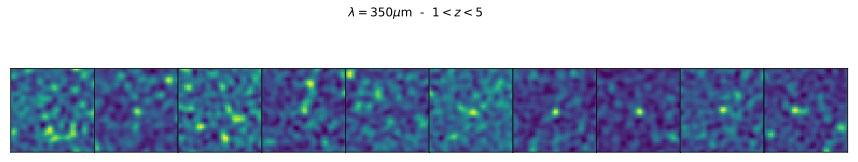

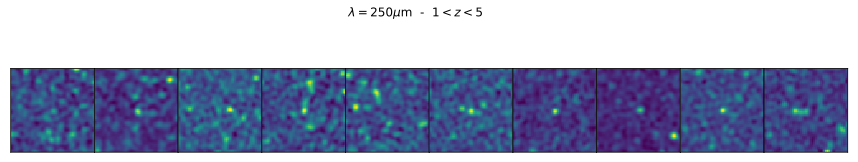

In [134]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1, 10, figsize=(15,3))
plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

for i in xrange(HotDOGs.shape[0]):
    axes[i,].imshow(HotDOGs_500[i])
plt.suptitle(r'$\lambda=500\mu$m  -  $1 < z < 5$')
plt.savefig('/Users/fbianchini/Research/StacktSZ/HotDOGs_500.pdf', bboxes_inches='tight')

fig, axes = plt.subplots(1, 10, figsize=(15,3))
plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

for i in xrange(HotDOGs.shape[0]):
    axes[i,].imshow(HotDOGs_350[i])
plt.suptitle(r'$\lambda=350\mu$m  -  $1 < z < 5$')
plt.savefig('/Users/fbianchini/Research/StacktSZ/HotDOGs_350.pdf', bboxes_inches='tight')

fig, axes = plt.subplots(1, 10, figsize=(15,3))
plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

for i in xrange(HotDOGs.shape[0]):
    axes[i,].imshow(HotDOGs_250[i])
plt.suptitle(r'$\lambda=250\mu$m  -  $1 < z < 5$')
plt.savefig('/Users/fbianchini/Research/StacktSZ/HotDOGs_250.pdf', bboxes_inches='tight')

In [135]:
from Fit2D import FitGauss2D

In [146]:
FitGauss2D(np.median(HD, axis=0))

0.0699754584504


(array([  6.99754585e-02,   2.55804458e+01,   2.54082314e+01,
          1.51564671e+00,   1.41781893e+00,  -3.98252450e-01,
         -1.01020690e-03]),
 array([[  3.16765951e-06,   8.21626683e-12,   1.93095366e-11,
          -3.43042568e-05,  -3.20942414e-05,   2.46773285e-10,
           1.09098776e-14],
        [  8.21626683e-12,   1.45822259e-03,   6.61432677e-05,
          -1.00440782e-10,  -5.42167851e-11,  -8.67951984e-10,
          -6.29915161e-15],
        [  1.93095366e-11,   6.61432677e-05,   1.32846380e-03,
          -1.10536465e-10,  -4.78236521e-10,   1.53171414e-09,
           5.15721664e-14],
        [ -3.43042568e-05,  -1.00440782e-10,  -1.10536465e-10,
           1.49387278e-03,   7.37074833e-06,  -1.50508885e-09,
          -1.81858883e-07],
        [ -3.20942414e-05,  -5.42167851e-11,  -4.78236521e-10,
           7.37074833e-06,   1.30758915e-03,  -1.00410926e-08,
          -1.70142796e-07],
        [  2.46773285e-10,  -8.67951984e-10,   1.53171414e-09,
          -1.50

In [144]:
HD = [HotDOGs_250[1],HotDOGs_250[3], HotDOGs_250[5], HotDOGs_250[6], HotDOGs_250[7], HotDOGs_250[8]]

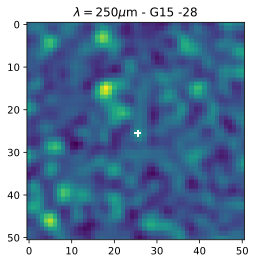

In [151]:
for patch in patches:
    for i in xrange(len(anal.cuts[250][patch][0])):
        plt.title(r'$\lambda=250\mu$m - '+patch+' -'+str(i))
        plt.imshow(anal.cuts[250][patch][0][i])
        plt.plot(25.5,25.5,'w+')
        plt.savefig('plots/'+str(patch)+'_%02d.pdf'%i, bboxes_inches='tight')


In [154]:
AmIReallyResolved(anal, 250, 'G9')

array([1, 2])

In [169]:
print anal.FitMe(np.median(HotDOGs_250, axis=0),)[0].amplitude/1e-3
print anal.FitMe(np.median(HotDOGs_350, axis=0),)[0].amplitude/1e-3
print anal.FitMe(np.median(HotDOGs_500, axis=0),)[0].amplitude/1e-3

57.1606987293
44.3645900599
25.0703616522


In [188]:
flux250 = []
flux350 = []
flux500 = []

for i in xrange(len(HotDOGs_250)):
    flux250.append(anal.FitMe(HotDOGs_250[i])[0].amplitude/1e-3)
    print anal.FitMe(HotDOGs_250[i])[0].amplitude/1e-3
flux250 = np.asarray(flux250)

print '~~~~~~'

for i in xrange(len(HotDOGs_350)):
    flux350.append(anal.FitMe(HotDOGs_350[i])[0].amplitude/1e-3)
    print anal.FitMe(HotDOGs_350[i])[0].amplitude/1e-3
flux350 = np.asarray(flux350)

print '~~~~~~'

for i in xrange(len(HotDOGs_500)):
    flux500.append(anal.FitMe(HotDOGs_500[i])[0].amplitude/1e-3)
    print anal.FitMe(HotDOGs_500[i])[0].amplitude/1e-3
flux500 = np.asarray(flux500)

24.8317908656
70.1973157523
22.6963378777
48.9663919787
-10.4482289781
41.2033009499
96.0425391085
97.3495542943
76.8411917756
57.3807335097
~~~~~~
11.4018613914
55.8456588888
37.1696153427
32.5870000083
-9.84117484216
36.0669549193
72.2796863617
91.9389303739
55.8980810359
60.2830474351
~~~~~~
10.3515427507
15.093705339
-3379.25977534
52.2479662389
-9.10316973095
30.5267591361
43.3924318952
62.9301808311
48.3485373705
41.6607270932


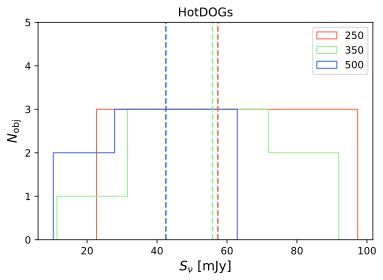

In [213]:
hist(flux250[flux250>0], 'knuth', label='250', histtype='step', color='tomato')
hist(flux350[flux350>0], 'knuth', label='350', histtype='step', color='lightgreen')
hist(flux500[flux500>0], 'knuth', label='500', histtype='step', color='royalblue')
# plt.axvline(np.mean(flux250[flux250>0]), ls='--', color='tomato')
# plt.axvline(np.mean(flux350[flux350>0]), ls='--', color='lightgreen')
# plt.axvline(np.mean(flux500[flux500>0]), ls='--', color='royalblue')
plt.axvline(np.median(flux250[flux250>0]), ls='--', color='tomato')
plt.axvline(np.median(flux350[flux350>0]), ls='--', color='lightgreen')
plt.axvline(np.median(flux500[flux500>0]), ls='--', color='royalblue')
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]', size=13)
plt.ylabel(r'$N_{\rm obj}$', size=13)
plt.ylim([0,5])
plt.title('HotDOGs')

In [214]:
fan_250 = np.asarray([204.6, 49.1 ,42.9 ,95.0 ,57.3 ,124.4, 107.5 ,51.4 ,44.4 ,63.6 ,92.3 ,56.6 ,69.0 ,66.5 ,94.0 ,36.4, 156.1, 123.9 ,88.3 ,133.9, 104.0, 101.8])

In [215]:
fan_350 = np.asarray([132.6 ,26.9 ,38.7 ,77.9 ,47.6, 128.8 ,76.3 ,38.0 ,44.1 ,71.1 ,89.1 ,42.9 ,55.1 ,48.2 ,80.8 ,35.6 ,136.2, 126.4, 57.9 ,94.0, 78.6, 74.4])

In [216]:
fan_500 = np.asarray([61.7, 36.3 ,33.9 , 39.0 ,26.3 ,99.0 ,48.9 ,28.4 ,30.7 ,51.4 ,58.9 ,20.8 ,35.6 ,31.4 ,38.6 ,29.5, 76.0 ,101.5 ,62.3 ,52.4 ,58.4 ])

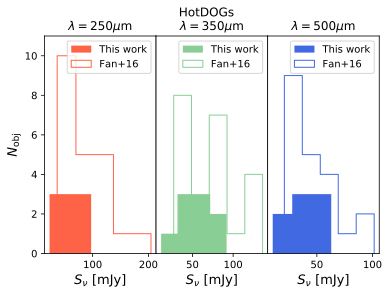

In [246]:
plt.figure(figsize=(6,4))
plt.subplot(131)
plt.title(r'$\lambda = 250\mu$m')
hist(flux250[flux250>0], 'knuth', label='This work', histtype='stepfilled', color='tomato')
hist(fan_250, 'knuth', label='Fan+16', histtype='step', color='tomato')
plt.ylim([0,11])
plt.ylabel(r'$N_{\rm obj}$', size=13)
plt.xlabel(r'$S_{\nu}$ [mJy]', size=13)
plt.legend()

plt.subplot(132)
plt.title(r'$\lambda = 350\mu$m')
hist(flux350[flux350>0], 'knuth', label='This work', histtype='stepfilled', color='#89CE94')
hist(fan_350, 'knuth', label='Fan+16', histtype='step', color='#89CE94')
plt.ylim([0,11])
plt.setp(plt.gca(), yticks=[])
plt.xlabel(r'$S_{\nu}$ [mJy]', size=13)
plt.legend()

plt.subplot(133)
plt.title(r'$\lambda = 500\mu$m')
hist(flux500[flux500>0], 'knuth', label='This work', histtype='stepfilled', color='royalblue')
hist(fan_500, 'knuth', label='Fan+16', histtype='step', color='royalblue')
plt.ylim([0,11])
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]', size=13)
plt.setp(plt.gca(), yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

plt.suptitle('HotDOGs')

plt.savefig('/Users/fbianchini/Research/StacktSZ/HotDOGs_our_n_Fan.pdf', bboxes_inches='tight')

In [6]:
anal_all = CutoutAnalysis('results_filt_H-ATLAS_W4_SN3/', zbins=zbins, extras_names=extras_names, lambdas=[100,160,250,350,500])


In [8]:
qso_cat = QSOcat(GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE'), zbins, W4only=1, SN_W4=3)

	...z-bin : 1.0 < z < 5.0


100 4.30913837634 0.668188946056
160 7.57656604908 1.44317286815
250 13.0003091423 1.40558102282
350 10.9511209942 1.44377970311
500 8.04545307027 1.23245962457


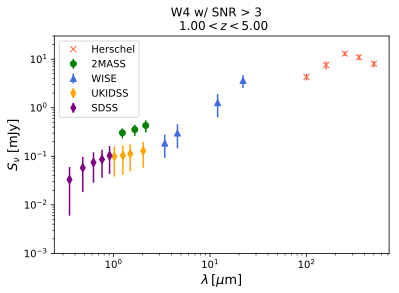

In [23]:
qso_cat.PlotFromAnal(0, anal=anal_all)
plt.suptitle('W4 w/ SNR > 3')
plt.savefig('/Users/fbianchini/Research/StacktSZ/SED_HotDOGs_W4_3sigma.pdf', bboxes_inches='tight')

In [33]:
qso_cat.cat[0]

,CC_FLAGS,DEC,ERR_FLUX02_12KEV,ERR_FLUX02_2KEV,ERR_FLUX2_12KEV,ERR_HMAG,ERR_JMAG,ERR_KMAG,ERR_W1MAG,ERR_W2MAG,...,W3MAG,W3SNR,W4CHI2,W4MAG,W4SNR,YFLUX,YFLUX_ERR,Z,Z_PCA,Z_VI
2,0000,4.829781,0.0,0.0,0.0,0.000,0.000,0.000,0.044,0.044000,...,10.764,9.7,0.0,8.056,5.3,5.525437e-31,3.595587e-32,1.618846,1.628610,1.618846
119,0000,-2.454577,0.0,0.0,0.0,0.000,0.000,0.000,0.042,0.053000,...,10.676,8.9,0.0,7.827,4.8,0.000000e+00,0.000000e+00,2.580668,2.621958,2.610000
154,0000,-6.683352,0.0,0.0,0.0,0.173,0.102,0.187,0.035,0.039000,...,10.019,16.5,0.0,7.809,5.4,0.000000e+00,0.000000e+00,2.576987,2.603254,2.606000
210,0000,10.773232,0.0,0.0,0.0,0.000,0.000,0.000,0.151,-999.999023,...,11.834,1.6,0.0,8.558,3.1,2.082397e-31,2.866109e-32,2.994400,3.005784,3.005000
270,0000,19.343593,0.0,0.0,0.0,0.000,0.000,0.000,0.067,0.083000,...,12.176,2.8,0.0,8.516,3.4,0.000000e+00,0.000000e+00,1.220556,1.221545,1.220556
323,0000,10.446029,0.0,0.0,0.0,0.000,0.000,0.000,0.064,0.073000,...,11.954,3.3,0.0,8.173,3.4,2.341553e-31,2.643880e-32,1.947469,1.963220,1.972000
413,0000,16.928382,0.0,0.0,0.0,0.000,0.000,0.000,0.032,0.034000,...,10.465,11.2,0.0,8.378,3.3,0.000000e+00,0.000000e+00,2.668209,1.173160,1.175000
438,0000,8.675986,0.0,0.0,0.0,0.000,0.000,0.000,0.177,0.200000,...,11.734,4.1,0.0,8.295,3.4,2.894158e-31,3.133642e-32,3.727806,3.710395,3.727806
460,0000,8.139255,0.0,0.0,0.0,0.000,0.000,0.000,0.046,0.048000,...,10.544,10.4,0.0,8.124,5.1,7.515960e-31,2.378490e-32,2.356221,2.361353,2.346000
467,0000,26.227419,0.0,0.0,0.0,0.000,0.000,0.000,0.062,0.086000,...,11.962,3.9,0.0,8.582,3.1,0.000000e+00,0.000000e+00,1.366167,1.366394,1.369000


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83333333,  0.86666667,  0.9       ,  0.93333333,  0.96666667,  1.        ]),
 <a list of 30 Patch objects>)

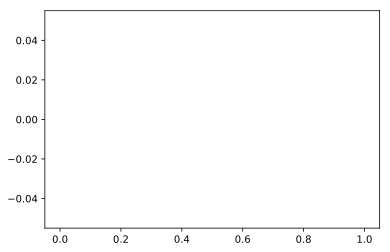

In [40]:
plt.hist(qso_cat.cat[0].W4MAG[qso_cat.cat[0].W4SNR < 2], 30)
# plt.hist(qso_cat.cat[0].W4MAG[qso_cat.cat[0].W4SNR > 2], 30)